In [40]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix

In [41]:
ref = cv2.imread('../../../images/depth_superres/reference.png')
ref = cv2.cvtColor(ref, cv2.COLOR_BGR2RGB)

target =  cv2.imread('../../../images/depth_superres/target.png', 0)
conf =  cv2.imread('../../../images/depth_superres/confidence.png', 0)


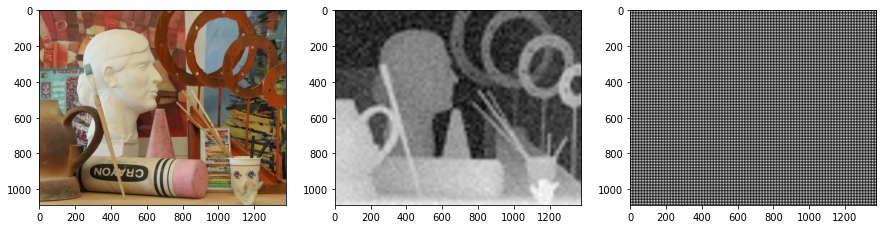

In [42]:
fig = plt.figure(figsize=(15,15))

plt.subplot(1,3,1)
plt.imshow(ref)

plt.subplot(1,3,2)
plt.imshow(target, cmap='gray')

plt.subplot(1,3,3)
plt.imshow(conf, cmap='gray')

-  We will use openCV RGB to YCrCb
- CSR Matrix = Compressed Row Matrix 
    - https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html

In [89]:
def get_coords(im,  sigma_spatial=32, sigma_luma=8, sigma_chroma=8):
    im_yCrCb = cv2.cvtColor(im, cv2.COLOR_RGB2YCrCb)

    # x_grid, y_grid has same shape (W, H) as input image
    y_grid, x_grid = np.mgrid[:im.shape[0], :im.shape[1]]

    # Spatial Coordinates
    coords_x = (x_grid / sigma_spatial).astype(int)
    coords_y = (y_grid / sigma_spatial).astype(int)

    # Luma Coordinates
    coords_luma = (im_yCrCb[:,:, 0] /sigma_luma).astype(int)

    # Chroma Coordinates
    coords_Cr = (im_yCrCb[:,:, 1] /sigma_chroma).astype(int)

    # Chroma Coordinates
    coords_Cb = (im_yCrCb[:,:, 2] /sigma_chroma).astype(int)

    # 5 Dimensional Coordinates
    coords = np.dstack((coords_x, coords_y, coords_luma, coords_Cr, coords_Cb))

    # Flattening the cordinates
    # Here no of rows = (WxH), i.e: no of pixels
    # no of cols = 5, i.e: (x, y, luma, cr, cb)
    coords = coords.reshape(-1, coords.shape[-1])

    return coords

def get_hash_coords(ndim, coords):
    # Hackey Hash Function
    # TODO: How does this hashing works?
    hashvec = (255 ** np.arange(ndim))
    hashcoords = coords @ hashvec
    
    # print('HashVec: ', hashvec)
    # print('Coords Shape, Hash Coords Shape: ', coords.shape, hashcoords.shape)

    # hash_uniq: the unique hashes
    # idx_uniq: indices of unique hashed in original array
    # idx_inv: can be used to create original array from hash_uniq
    hash_uniq, idx_uniq, idx_inv =  np.unique(hashcoords, return_index=True, return_inverse=True)

    # Getting unique vertices
    uniqcoords = coords[idx_uniq]
    assert hash_uniq.shape[0] == uniqcoords.shape[0], 'No of uniq hashes and no of uniq cords dont match!'

    return hashcoords, hash_uniq, idx_uniq, idx_inv, uniqcoords



In [90]:

def factorize(im, sigma_spatial=32, sigma_luma=8, sigma_chroma=8):
    
    # Getting 5 dimensional coordinates(npixels x 5)
    coords = get_coords(im)
    npixels, ndim = coords.shape
    print('Number of pixels, dims: ', npixels, ndim)


    # Hashing the cords
    hashcoords, hash_uniq, idx_uniq, idx_inv, uniqcoords = get_hash_coords(ndim, coords)
    nvertices = uniqcoords.shape[0]
    print('Number of vertices: ', nvertices)



    # Constructing the sparse Splat matrix to go from pixel -> vertices
    # TODO: How does this procedure work?
    S = csr_matrix((np.ones(npixels), (idx_inv, np.arange(npixels))))
    print('Sparse Matrix Shape: ', S.shape)





In [91]:
factorize(ref)

Number of pixels, dims:  1497088 5
Number of vertices:  63882
Sparse Matrix Shape:  (63882, 1497088)


In [76]:
help(csr_matrix)

Help on class csr_matrix in module scipy.sparse.csr:

class csr_matrix(scipy.sparse.compressed._cs_matrix)
 |  csr_matrix(arg1, shape=None, dtype=None, copy=False)
 |  
 |  Compressed Sparse Row matrix
 |  
 |  This can be instantiated in several ways:
 |      csr_matrix(D)
 |          with a dense matrix or rank-2 ndarray D
 |  
 |      csr_matrix(S)
 |          with another sparse matrix S (equivalent to S.tocsr())
 |  
 |      csr_matrix((M, N), [dtype])
 |          to construct an empty matrix with shape (M, N)
 |          dtype is optional, defaulting to dtype='d'.
 |  
 |      csr_matrix((data, (row_ind, col_ind)), [shape=(M, N)])
 |          where ``data``, ``row_ind`` and ``col_ind`` satisfy the
 |          relationship ``a[row_ind[k], col_ind[k]] = data[k]``.
 |  
 |      csr_matrix((data, indices, indptr), [shape=(M, N)])
 |          is the standard CSR representation where the column indices for
 |          row i are stored in ``indices[indptr[i]:indptr[i+1]]`` and their
 | 